In [1]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

# Reproducibility
SEED = 42
np.random.seed(SEED)


In [5]:
df = pd.read_csv("titanic_augmented.csv")

df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,is_alone,ticket_group_size,fare_per_person,age_fare_ratio,cabin_deck,cabin_room_number,booking_reference,service_id,cabin_score,name_word_count
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,7.250,3.034483,Unknown,NaN,92490,221958,6.134152,4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,71.283,0.533084,C,85.0,15655423,771155,4.182430,7
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,1,7.925,3.280757,Unknown,NaN,90218500,231932,9.327285,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,2,26.550,0.659134,C,123.0,2493079,465838,8.660639,7
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,1,8.050,4.347826,Unknown,NaN,59517148,359178,0.452187,4


In [6]:
df.info()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        891 non-null    int64  
 1   Survived           891 non-null    int64  
 2   Pclass             891 non-null    int64  
 3   Name               891 non-null    object 
 4   Sex                891 non-null    object 
 5   Age                714 non-null    float64
 6   SibSp              891 non-null    int64  
 7   Parch              891 non-null    int64  
 8   Ticket             891 non-null    object 
 9   Fare               891 non-null    float64
 10  Cabin              204 non-null    object 
 11  Embarked           889 non-null    object 
 12  name_length        891 non-null    int64  
 13  title              891 non-null    object 
 14  title_group        891 non-null    object 
 15  family_size        891 non-null    int64  
 16  is_alone           891 non

PassengerId            0
Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                  177
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                687
Embarked               2
name_length            0
title                  0
title_group            0
family_size            0
is_alone               0
ticket_group_size      0
fare_per_person        0
age_fare_ratio         0
cabin_deck             0
cabin_room_number    691
booking_reference      0
service_id             0
cabin_score            0
name_word_count        0
dtype: int64

In [7]:
#feature selection
TARGET = "Survived"

drop_cols = [
    "PassengerId",
    "Name",
    "Ticket",
    "Cabin",
    "booking_reference",
    "service_id"
]

X = df.drop(columns=[TARGET] + drop_cols)
y = df[TARGET]

X.shape, y.shape


((891, 19), (891,))

In [8]:
#data splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=SEED
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Train survival rate:", y_train.mean())
print("Test survival rate:", y_test.mean())


Train size: (668, 19)
Test size: (223, 19)
Train survival rate: 0.38323353293413176
Test survival rate: 0.38565022421524664


In [9]:
#feature typing
num_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", num_features)
print("Categorical features:", cat_features)


Numeric features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'name_length', 'family_size', 'is_alone', 'ticket_group_size', 'fare_per_person', 'age_fare_ratio', 'cabin_room_number', 'cabin_score', 'name_word_count']
Categorical features: ['Sex', 'Embarked', 'title', 'title_group', 'cabin_deck']


In [10]:
#data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop"
)

preprocessor

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed train shape:", X_train_processed.shape)
print("Processed test shape :", X_test_processed.shape)


Processed train shape: (668, 46)
Processed test shape : (223, 46)


array([[-1.5793344 ,  0.40533335,  0.53667675, ...,  0.        ,
         0.        ,  0.        ],
       [-0.37637502, -0.82976403, -0.46472009, ...,  0.        ,
         0.        ,  1.        ],
       [-0.37637502,  0.32813977, -0.46472009, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.82658437,  1.40884998,  0.53667675, ...,  0.        ,
         0.        ,  1.        ],
       [-1.5793344 ,  1.33165639, -0.46472009, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.82658437, -0.21221534, -0.46472009, ...,  0.        ,
         0.        ,  1.        ]])

# Logistic Regression

In [14]:
# =========================
# Logistic Regression
# =========================

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# --- 2) Model pipeline ---
logreg_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(solver="liblinear", max_iter=2000, random_state=SEED))
])

# --- 3) CV + tuning ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

param_grid = {
    "model__penalty": ["l1", "l2"],
    "model__C": [0.01, 0.1, 1, 10]
}

grid = GridSearchCV(
    logreg_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_logreg = grid.best_estimator_

print("Best params:", grid.best_params_)
print("Best CV ROC AUC:", grid.best_score_)

# --- 4) Final test evaluation ---
y_pred = best_logreg.predict(X_test)
y_prob = best_logreg.predict_proba(X_test)[:, 1]

print("Test ROC AUC:", roc_auc_score(y_test, y_prob))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# --- 5) Interpretation (odds ratios) ---
ohe = best_logreg.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_cols = best_logreg.named_steps["preprocess"].transformers_[1][2]  # selector result
num_cols = best_logreg.named_steps["preprocess"].transformers_[0][2]

feature_names = list(num_cols) + list(ohe.get_feature_names_out(cat_cols))
coefs = best_logreg.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "odds_ratio": np.exp(coefs)
}).sort_values("odds_ratio", ascending=False)

display(coef_df.head(10))
display(coef_df.tail(10).sort_values("odds_ratio"))

if grid.best_params_["model__penalty"] == "l1":
    print("Zero coefficients:", (coefs == 0).sum(), "out of", len(coefs))

Best params: {'model__C': 1, 'model__penalty': 'l1'}
Best CV ROC AUC: 0.8666237292177208
Test ROC AUC: 0.8583432354438975
Test Accuracy: 0.8295964125560538
Confusion matrix:
 [[118  19]
 [ 19  67]]


,feature,coef,odds_ratio
14,Sex_female,1.676755,5.348174
40,cabin_deck_D,0.931281,2.537757
32,title_group_Master,0.907336,2.477712
41,cabin_deck_E,0.710120,2.034235
25,title_Master,0.589673,1.803399
4,Fare,0.408461,1.504500
35,title_group_Mrs,0.323619,1.382120
12,cabin_score,0.212829,1.237173
5,name_length,0.144612,1.155592
17,Embarked_Q,0.138369,1.148399


,feature,coef,odds_ratio
28,title_Mr,-1.026383,0.358301
45,cabin_deck_Unknown,-0.683502,0.504846
0,Pclass,-0.568119,0.566590
1,Age,-0.417937,0.658404
6,family_size,-0.400902,0.669716
18,Embarked_S,-0.330090,0.718859
30,title_Rev,-0.293296,0.745801
9,fare_per_person,-0.206427,0.813486
2,SibSp,-0.201366,0.817613
8,ticket_group_size,-0.125561,0.882002


Zero coefficients: 22 out of 46


# reduced features

In [15]:
drop_more = [
    "name_length",
    "name_word_count",
    "ticket_group_size",
    "fare_per_person",
    "age_fare_ratio",
    "cabin_room_number",
    "cabin_score",
    "title"
]

X_reduced = df.drop(columns=[TARGET] + drop_cols + drop_more)
y = df[TARGET]

X_reduced.shape

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reduced,
    y,
    test_size=0.25,
    stratify=y,
    random_state=SEED
)

num_features_r = Xr_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features_r = Xr_train.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer_r = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_r = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_r = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_r, num_features_r),
        ("cat", categorical_transformer_r, cat_features_r)
    ],
    remainder="drop"
)

logreg_simple = Pipeline([
    ("preprocess", preprocessor_r),
    ("model", LogisticRegression(
        solver="liblinear",
        max_iter=2000,
        random_state=SEED
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

param_grid = {
    "model__penalty": ["l1", "l2"],
    "model__C": [0.01, 0.1, 1, 10]
}

grid_simple = GridSearchCV(
    logreg_simple,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

grid_simple.fit(Xr_train, yr_train)

print("Best params (simple):", grid_simple.best_params_)
print("Best CV AUC (simple):", grid_simple.best_score_)

best_simple = grid_simple.best_estimator_

yr_pred = best_simple.predict(Xr_test)
yr_prob = best_simple.predict_proba(Xr_test)[:, 1]

print("Simple model accuracy:", accuracy_score(yr_test, yr_pred))
print("Simple model ROC AUC :", roc_auc_score(yr_test, yr_prob))


Best params (simple): {'model__C': 1, 'model__penalty': 'l1'}
Best CV AUC (simple): 0.8694397056274983
Simple model accuracy: 0.820627802690583
Simple model ROC AUC : 0.8685707010694279


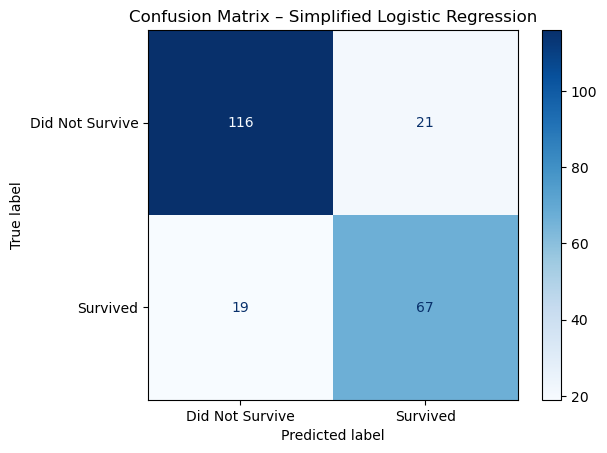

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(yr_test, yr_pred)  # simplified model, threshold 0.5

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Did Not Survive", "Survived"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Simplified Logistic Regression")
plt.show()


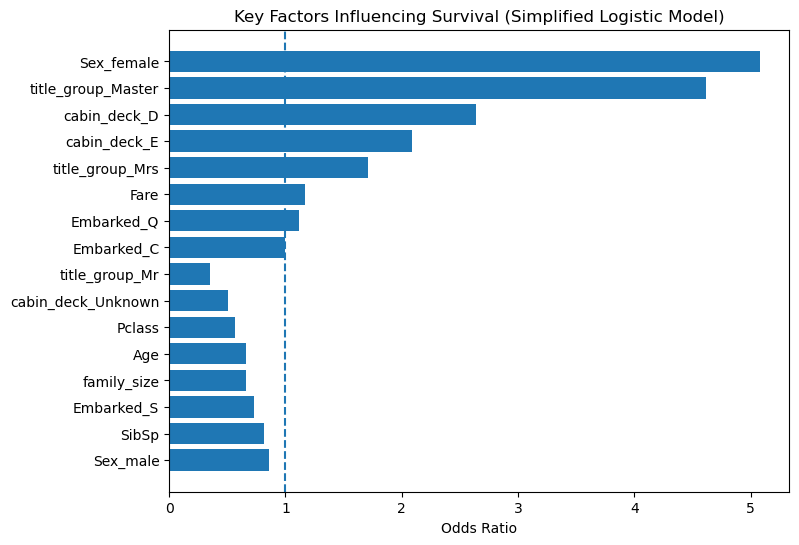

In [17]:
# Get feature names
feature_names_num_r = num_features_r
feature_names_cat_r = (
    best_simple.named_steps["preprocess"]
    .named_transformers_["cat"]
    .named_steps["onehot"]
    .get_feature_names_out(cat_features_r)
)

feature_names_r = list(feature_names_num_r) + list(feature_names_cat_r)

coefs_r = best_simple.named_steps["model"].coef_[0]

coef_df_r = pd.DataFrame({
    "feature": feature_names_r,
    "odds_ratio": np.exp(coefs_r)
})

# Select strongest effects
top_pos = coef_df_r.sort_values("odds_ratio", ascending=False).head(8)
top_neg = coef_df_r.sort_values("odds_ratio").head(8)

plot_df = pd.concat([top_pos, top_neg])

plt.figure(figsize=(8, 6))
plt.barh(plot_df["feature"], plot_df["odds_ratio"])
plt.axvline(1, linestyle="--")
plt.xlabel("Odds Ratio")
plt.title("Key Factors Influencing Survival (Simplified Logistic Model)")
plt.gca().invert_yaxis()
plt.show()


# adjust the decision threshold

In [18]:
import numpy as np

threshold = 0.45
y_pred_045 = (yr_prob >= threshold).astype(int)

print("Accuracy:", accuracy_score(yr_test, y_pred_045))
print("Recall  :", recall_score(yr_test, y_pred_045))
print("Precision:", precision_score(yr_test, y_pred_045))


Accuracy: 0.8161434977578476
Recall  : 0.7906976744186046
Precision: 0.7472527472527473


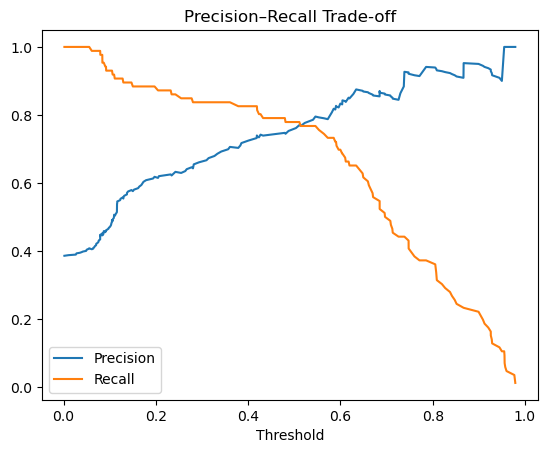

In [19]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(yr_test, yr_prob)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision–Recall Trade-off")
plt.show()


# Compare logictic version

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# --- Model 1: Full Logistic (threshold = 0.50) ---
full_pred = y_pred
full_prob = y_prob

# --- Model 2: Simplified Logistic (threshold = 0.50) ---
simple_pred_05 = yr_pred
simple_prob = yr_prob

# --- Model 3: Simplified Logistic (threshold = 0.45) ---
simple_pred_045 = y_pred_045

results = pd.DataFrame([
    {
        "Model": "Full Logistic (L1, thr=0.50)",
        "Accuracy": accuracy_score(y_test, full_pred),
        "Precision": precision_score(y_test, full_pred),
        "Recall": recall_score(y_test, full_pred),
        "F1": f1_score(y_test, full_pred),
        "ROC AUC": roc_auc_score(y_test, full_prob)
    },
    {
        "Model": "Simplified Logistic reduced features (L1, thr=0.50)",
        "Accuracy": accuracy_score(yr_test, simple_pred_05),
        "Precision": precision_score(yr_test, simple_pred_05),
        "Recall": recall_score(yr_test, simple_pred_05),
        "F1": f1_score(yr_test, simple_pred_05),
        "ROC AUC": roc_auc_score(yr_test, simple_prob)
    },
    {
        "Model": "Simplified Logistic (L1, thr=0.45)",
        "Accuracy": accuracy_score(yr_test, simple_pred_045),
        "Precision": precision_score(yr_test, simple_pred_045),
        "Recall": recall_score(yr_test, simple_pred_045),
        "F1": f1_score(yr_test, simple_pred_045),
        "ROC AUC": roc_auc_score(yr_test, simple_prob)
    }
])

results.round(3)


,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,"Full Logistic (L1, thr=0.50)",0.830,0.779,0.779,0.779,0.858
1,"Simplified Logistic reduced features (L1, thr=...",0.821,0.761,0.779,0.770,0.869
2,"Simplified Logistic (L1, thr=0.45)",0.816,0.747,0.791,0.768,0.869
